In [9]:
import sys 
if '..' not in sys.path:
    sys.path.append('../')
from utils import *

import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader


## NN - Transformer

In [21]:

def split_data(X, y, test_size=0.2):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    return X_train, X_test, y_train, y_test

def calculate_position_difference(y):
    for i in range(len(y)):
        y[i] -= y[i][0]
    return y

# data loading
folder_path = '/Users/antongolles/Documents/uni/masters/myMasters/applied_machine_learning/inertial_navigation_transformer/data/data_from_RoNIN/train_dataset_1/'
params = {'Ntrain': 1_000_000, 'Nval': 100, 'seq_len': 1000, 
          'input': ['synced/acce', 'synced/magnet', 'synced/gyro'], 
          'output': ['pose/tango_pos'], 
          'normalize': False}
X, y = load_split_data(folder_path, **params)

# Calculate position difference
y = calculate_position_difference(y)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = split_data(X, y)

# Convert to PyTorch tensors
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
y_test = torch.tensor(y_test, dtype=torch.float32).to(device)

print(X.shape, y.shape)

(1000, 1000, 9) (1000, 1000, 3)


In [22]:
class PositionPredictor(nn.Module):
    def __init__(self, d_model, nhead, num_layers, dim_feedforward):
        super(PositionPredictor, self).__init__()
        self.d_model = d_model
        self.nhead = nhead
        self.num_layers = num_layers
        self.dim_feedforward = dim_feedforward

        self.transformer_encoder = nn.TransformerEncoder(
            encoder_layer=nn.TransformerEncoderLayer(d_model, nhead, dim_feedforward, dropout=0.1),
            num_layers=num_layers
        )
        self.fc1 = nn.Linear(d_model, d_model)  # 3 for (x, y, z) position
        self.fc2 = nn.Linear(d_model, 3)
        #self.flatten = nn.Flatten()

    def forward(self, src):
        output = self.transformer_encoder(src)

        output = F.relu(self.fc1(output))  # Add a ReLU activation function
        output = self.fc2(output)

        return output
    


# Initialize model
d_model = X.shape[-1]  # 4 (from ori) + 3 (from w) + 3 (from a) + 3 (from m)
nhead = 1
num_layers = 6
dim_feedforward = 256
model = PositionPredictor(d_model, nhead, num_layers, dim_feedforward)

batch_size = 32

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Prepare DataLoader
train_dataset = TensorDataset(X_train.to(device), y_train.to(device))
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = TensorDataset(X_test.to(device), y_test.to(device))
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [23]:
# Hyperparameters
epochs = 100
learning_rate = 0.01

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Move model to the configured device
model = model.to(device)
# try load model weights
try:
    model.load_state_dict(torch.load(f'checkpoint_{model.__class__.__name__}.pt'))
    print("Model weights loaded!")
except:
    print("No model weights found!")
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), f'checkpoint_{model.__class__.__name__}.pt')
        self.val_loss_min = val_loss



early_stopping = EarlyStopping(patience=30, verbose=True)
# Training loop
for epoch in range(epochs):
    model.train()  # Set the model to training mode
    for i, (X_batch, y_batch) in enumerate(train_loader):
        # Forward pass
        outputs = model(X_batch)
        #print(outputs.shape, y_batch.shape)
        loss = criterion(outputs[:,-1:,:], y_batch[:,-1:,:])

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Validation loop
    model.eval()  # Set the model to evaluation mode
    val_loss = 0
    with torch.no_grad():
        for i, (X_batch, y_batch) in enumerate(val_loader):
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()

    

    val_loss = val_loss / len(val_loader)

    early_stopping(val_loss, model)
    if early_stopping.early_stop:
            print("Early stopping")
            break

    print(f'Epoch {epoch+1}/{epochs}, Training Loss: {loss.item()}, Validation Loss: {val_loss}')


Model weights loaded!
Validation loss decreased (inf --> 1.446638).  Saving model ...
Epoch 1/100, Training Loss: 0.8798456192016602, Validation Loss: 1.4466380391802107
EarlyStopping counter: 1 out of 30
Epoch 2/100, Training Loss: 0.8853306770324707, Validation Loss: 1.4489610195159912
EarlyStopping counter: 2 out of 30
Epoch 3/100, Training Loss: 0.887209415435791, Validation Loss: 1.4510108573096139
EarlyStopping counter: 3 out of 30
Epoch 4/100, Training Loss: 0.883568286895752, Validation Loss: 1.4488204036440169
EarlyStopping counter: 4 out of 30
Epoch 5/100, Training Loss: 0.8879936337471008, Validation Loss: 1.4507309453827995
EarlyStopping counter: 5 out of 30
Epoch 6/100, Training Loss: 0.8838785290718079, Validation Loss: 1.4510753750801086
EarlyStopping counter: 6 out of 30
Epoch 7/100, Training Loss: 0.8878362774848938, Validation Loss: 1.4508255975587028
EarlyStopping counter: 7 out of 30
Epoch 8/100, Training Loss: 0.8866091370582581, Validation Loss: 1.4508029988833837

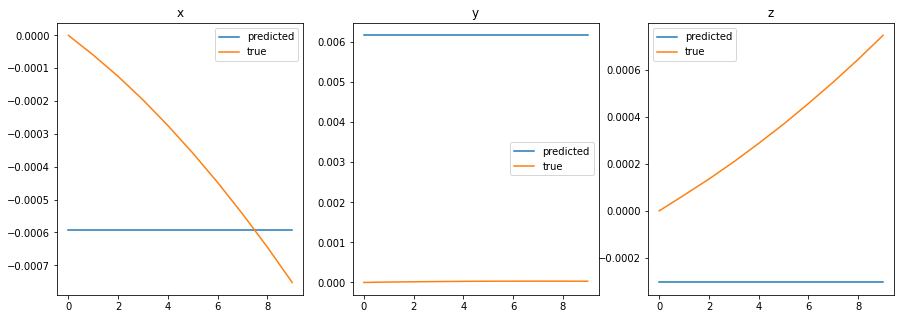

In [19]:
# get predictions
model.eval()

with torch.no_grad():
    for i, (X_batch, y_batch) in enumerate(val_loader):
        if i < 10:
            outputs = model(X_batch)
            break
    
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
for i, l in enumerate(list('xyz')):
    ax[i].plot(outputs[0, :, i].cpu().numpy(), label='predicted')
    ax[i].plot(y_batch[0, :, i].cpu().numpy(), label='true')
    ax[i].set_title(l)
    ax[i].legend()
